# **Object Oriented Programming (OOP)**

In [ ]:
# Class : A Blueprint
# Object :
# Attributes :
# Methods : Function
# Inheritance :

In [1]:
# Define Car class

class Car:
    def __init__(self, company, model, year):
        self.company = company
        self.model = model
        self.year = year

    def start(self):
        print(f"{self.model} {self.year} is started ...")

    def stop(self):
        print(f"{self.model} {self.year} is stopped ...")

In [2]:
my_car1 = Car("Toyota", "Corolla", "2023")
my_car2 = Car("Saipa", "Quick", "1403")

In [4]:
my_car1.start()

Corolla 2023 is started ...


In [6]:
my_car2.stop()

Quick 1403 is stopped ...


In [7]:
class ElectricalCar(Car):
    def __init__(self, company, model, year, battery_capacity):
        super().__init__(company, model, year)
        self.battery_capacity = battery_capacity

    def charge(self):
        print(f"{self.model} {self.year} is charging ...")


In [8]:
my_car3 = ElectricalCar('Tesla', 'Model S', 2024, 1000)

In [11]:
my_car3.charge()

Model S 2024 is charging ...


# **Initialization**

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install swig
!pip install gym[box2d]

In [12]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
import glob
import io
import base64
import pygame
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import seaborn as sns
sns.set()
gymlogger.set_level(40) #error only
pygame.init()
pygame.font.init()

In [13]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

# **Test a random agent**

In [16]:
env = wrap_env(gym.make("CartPole-v0"))
observation = env.reset()
done = False
while not done:

    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

env.close()
show_video()

# **Import necessary libraries**

In [17]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

# **Create and prepare the environment**

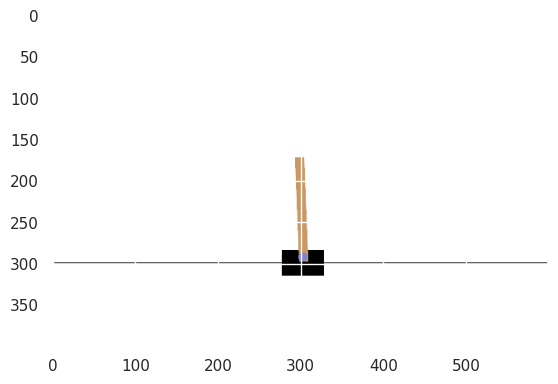

In [18]:
env = gym.make("CartPole-v0")
env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [23]:
env.action_space.n

2

In [24]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"State Space: {state_dims}, Action Space: {num_actions}")

State Space: 4, Action Space: 2


In [26]:
env.reset()

array([ 0.04534898,  0.0056615 ,  0.01618227, -0.00435412], dtype=float32)

In [27]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    # Wrapping env.reset()
    def reset(self):
        obs = self.env.reset()
        # [[0, 1]]
        return torch.from_numpy(obs).unsqueeze(dim=0).float()

    # Wrapping env.step()
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        # [[15]]
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)

        return next_state, reward, done, info

In [28]:
env = PreprocessEnv(env)

In [29]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)

In [30]:
print(f"State: {state}")
print(f"next_state: {next_state}, reward: {reward}, done: {done}")

State: tensor([[-0.0100,  0.0246,  0.0285,  0.0216]])
next_state: tensor([[-0.0095, -0.1709,  0.0290,  0.3231]]), reward: tensor([[1.]]), done: tensor([[False]])


# **Create the Q-Network**

In [49]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)

# **Create the target Q-Network**

In [50]:
target_q_network = copy.deepcopy(q_network).eval()

In [34]:
target_q_network

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

# **Create the $\epsilon$-greedy policy**

In [35]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

# **Create the experiance replay buffer**

In [38]:
my_a = torch.tensor([1, 2, 3, 4])
my_b = torch.tensor([1, 2, 3, 4])
my_c = torch.tensor([1, 2, 3, 4])
my_d = torch.tensor([1, 2, 3, 4])
my_abcd = torch.stack([my_a, my_b, my_c, my_d]).t()

In [39]:
my_abcd

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]])

In [41]:
[list(items) for items in my_abcd]

[[tensor(1), tensor(1), tensor(1), tensor(1)],
 [tensor(2), tensor(2), tensor(2), tensor(2)],
 [tensor(3), tensor(3), tensor(3), tensor(3)],
 [tensor(4), tensor(4), tensor(4), tensor(4)]]

In [42]:
class ReplayMemory:
    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # insert [s, a, r, s']
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    # sample [[s, a, r, s'], [s, a, r, s'], ...]
    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        batch = random.sample(self.memory, batch_size)
        # [[s, s, s], [a, a, a], ...]
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

# **Implement the algorithm**

In [48]:
def deep_q_learning(q_network, policy, episodes, alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.2):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    total_rewards = []

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)

                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()

            state = next_state
            ep_return += reward.item()

        total_rewards.append(ep_return)
        if episode & 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return total_rewards

In [51]:
total_rewards = deep_q_learning(q_network, policy, 550)

100%|██████████| 550/550 [02:13<00:00,  4.13it/s]


# **Test Agent**

In [54]:
env_test = wrap_env(PreprocessEnv(gym.make("CartPole-v0")))
observation = env_test.reset()
done = False
while not done:

    env_test.render()
    action = policy(observation)
    observation, reward, done, info = env_test.step(action)

env_test.close()
show_video()